# Social media and mental health correlation project



## Mental Health and Social Media - A growing problem

## Data sources and Structure

In this project, I will a preexisting CSV file data provided by a research project for the Statistics Course STA-2101 for the University of Liberal Arts Bangladesh (ULAB). Submitted to - Khan Raqib Mahmud. Submitted by - Souvik Ahmed (203014004) and Muhesena Nasiha Syeda (203014015). 

Found on Kaggle Databases.
kaggle.com

In [ ]:
#import libraries needed to run analysis and visualise the data
import pandas as pd #data manipultation
import numpy as np #maths stuff
import scipy.stats as stats #stats 
import matplotlib.pyplot as plt #visualisation
import seaborn as sns #visualisation

Now that I've imported the libraries I need, I shall fetch the data and start pre processing the data.

In [ ]:
#I've created a separate filepath.py function to record my directory. 
from filepath import filepath
#read the data - "filepath" should be replaced with the directory you store the smmh.csv file on your own device.
rawdata = pd.read_csv(filepath)
rawdata.head()

## Data Cleaning and Transformation



### Unecessary columns
Firstly, I don't need the timestamp data, so I'll remove that from the dataset. Then, to create an easy-to-use dataset, I would like to rename all the columns to workable titles and sort the question data into chronological order.

In [ ]:
#deleting timestamp column 
notimedata = rawdata.drop(['Timestamp'], axis=1)

#rename the columns for useability. 
#Let's create a new data frame: 
newdata = pd.DataFrame(notimedata)
newdata.columns = ['Age', 'Gender', 'Relationship Status', 
                   'Occupation', 'Affiliations', 
                   'Use Social Media', 'Platforms Used', 'Time Spent', 
                   'Attention Q1', 'Attention Q2', 'Anxiety Q1', 
                   'Attention Q3', 'Anxiety Q2', 'Attention Q4', 
                   'Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3', 
                   'Depression Q1', 'Depression Q2', 'Depression Q3'
                   ]


#Checking that the titles are correct
newdata.head()
list(newdata.columns)

#Sorting the data so that the questions are in alphabetical and chronological order
#Create two data frames, one with demographic data (first object) and the other with questions that are sorted by column. 

data = pd.concat([newdata[['Age', 'Gender', 'Relationship Status', 
                   'Occupation', 'Affiliations', 
                   'Use Social Media', 'Platforms Used', 'Time Spent',]], 
                  newdata[['Attention Q1', 'Attention Q2', 'Anxiety Q1', 
                   'Attention Q3', 'Anxiety Q2', 'Attention Q4', 
                   'Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3', 
                   'Depression Q1', 'Depression Q2', 'Depression Q3']].sort_index(axis=1)], 
                 ignore_index=False,axis=1)
data.head()

#Just in case, manually check the first entry of the new df to the original raw data to ensure that the scores matched the original dataset. We're all good!

### Finding and filling blank values

Looking for NaNs!

In [ ]:
#Finding the rows and columns that have null values.
np.where(pd.isnull(data))

Looks like we have missing values in the 'Affiliations' column. 

Since the rest of the "Affiliations" data is a string, I'm going to replace all the NaNs with 'Unknown'

In [ ]:
#Replace NaNs with "Unknown"
data = data.fillna('Unknown')
#Check that we don't have NaNs
np.where(pd.isnull(data))

### Checking the validity of responses

To make sure that the data shows participants that haven't created odd entries, let's check the responses for the fields that require manual input. Where 'Other' was selected, let's see what people have said. 

In [ ]:
#What are the unique values in my dataset and are they super weird / to be excluded? 
for col in data: 
    print(data[col].unique())

The 'Gender' data needs attention.

Looks like we have two changes to make in the 'Gender' column: 
1. Exclude the participant data that gave the "There are others???" response
2. Change the names of Non-binary entries to have the same format: "Non-binary"

In [ ]:
# Dropping the entry "There are others???" entry
data.drop(data.loc[data['Gender']=="There are others???"].index, inplace=True)

#Renaming the indices: Nonbinary, NB, Non binary
data['Gender'].replace(['Nonbinary ', 'NB', 'Non binary ', 'unsure ', 'Trans', 'Non-binary'], 
                    ['Other', 'Other', 'Other', 'Other', 'Other', 'Other'], inplace=True)

#check that it worked
print(data['Gender'].unique())

The 'Age' column is a float. So let's convert that.

In [ ]:
#convert float to int
data['Age'] = data['Age'].astype(int)

#check
display(data['Age'].dtypes)

### Making our data more readable

1. The "Time Spent" on social media values are long. 
2. It'd also be helpful to create a new column for "Time Spent" that's an integer of the mean time spent for further analysis and modelling later.


In [ ]:
#Create more readable values
data['Time Spent'].replace(['Between 2 and 3 hours', 'More than 5 hours', 'Between 3 and 4 hours',
 'Less than an Hour', 'Between 1 and 2 hours', 'Between 4 and 5 hours'], 
                           ['2-3 hours', '>5 hours', '3-4 hours', '<1 hour', '1-2 hours', '4-5 hours'], 
                           inplace=True)

#check 
print(data['Time Spent'].unique())

#Create a column of time spent as an integer.
#Specify conditions for our new time values to be assigned.
conditions = [
    (data['Time Spent'] == '<1 hour'),
    (data['Time Spent'] == '1-2 hours'),
    (data['Time Spent'] == '2-3 hours'),
    (data['Time Spent'] == '3-4 hours'), 
    (data['Time Spent'] == '4-5 hours'), 
    (data['Time Spent'] == '>5 hours'), 
]
     
#Creating time values using the upper bounds of the range given (to avoid using 0 on the <1 values)
time_values = [1, 2, 3, 4, 5, 6]

#Create a new column for Time Spent with our new values for each categorical time slot.
data['Time (hrs)'] = np.select(conditions, time_values)
data.head()

#Check that no weird values have popped up
print(data['Time (hrs)'].unique())


### Platforms used

Does the number of social media platforms used affect mental health scores? 

Assuming that the more time we spend on social media, the more likely we are to use other platforms. 

To find out if there's a relationship there, we need to first create a column for the number of platforms the participants use:

In [ ]:
#Creating a new column 'platform count' where we are counting the platforms used, 
#by using a function that splits the strings within the column.
data['Platform Count'] = data['Platforms Used'].apply(lambda x: len(x.split()))
data.head()

### Mental Health Scoring

We have multiple changes to make to our mental health scoring data:

1. One mental health questionnaire needs to be tranformed to reflect an accurate mental health score. 
2. Creating total questionnaire scores
3. Creating a total (overall) mental health score from all the questionnaires
4. Adding a mental health score "Outcome" column which will indicate whether a participant is experiencing severe mental health symptoms or not.

**Self esteem Question 2**

Our assumption is that higher scores indicate negatively affected mental health. Self esteem question 2 works in reverse, where higher scores are associated with positive mental health. So, we need to convert this question so that the numbers, when summed to a total mental health score, accurately represent that a high score indicates negative effects on mental health. 

The default score is as follows: 
- Very Negative - 1
- Slightly Negative - 2
- Neutral - 3 
- Slightly Positive - 4
- Very positive - 5


To create an accurate depiction of the effect of social media on mental health, including any positive effects, I will simply reverse the scoring, as seen below: 
- Very Negative - 5
- Slightly Negative - 4
- Neutral - 3 
- Slightly Positive - 2
- Very positive - 1

In [ ]:
#Create conditions again

selfesteem_conditions = [
    (data['Self Esteem Q2'] == 1), 
    (data['Self Esteem Q2'] == 2), 
    (data['Self Esteem Q2'] == 3), 
    (data['Self Esteem Q2'] == 4), 
    (data['Self Esteem Q2'] == 5)
]

new_esteem_values = [5, 4, 3, 2, 1]

#assign new values in the self esteem column
data['Self Esteem Q2'] = np.select(selfesteem_conditions, new_esteem_values)
data.head()

**Total Scores for Mental Health**

To find out broadly how social media affects mental well being, let's get a total score from all the questionnaires. To dig deeper into potential interactions of mental health with each category (depression, attention, self-esteem), let's create new columns for these separate totals, too.

In [ ]:
#Summing anxiety scores
data['Anxiety Score'] = data['Anxiety Q1'] + data['Anxiety Q2'] 

#Sum attention scores
data['Attention Score'] = data['Attention Q1'] + data['Attention Q2'] + data['Attention Q3'] + data['Attention Q4']

#Sum Depression Scores 
data['Depression Score'] = data['Depression Q1'] + data['Depression Q2'] + data['Depression Q3']

#Sum Self Esteem Scores 
data['Self Esteem Score'] = data['Self Esteem Q1'] + data['Self Esteem Q2'] + data['Self Esteem Q3']

#Total mental health score 
data['Total Score'] = data['Self Esteem Score'] + data['Depression Score'] + data['Attention Score'] + data['Anxiety Score']

#See the scores
data.head()

**Mental Health Outcomes**

A total mental health score exceeding 40 likely indicates that the participant is experiencing severe mental health symptoms. Outcomes can also be very useful for classifying whether a dataset is likely to belong to someone experiencing mental health symptoms. This way, we can predict outcomes based on the features of our data.

Any score below 40 is deemed as not experiencing severe mental health symptoms, and will be given the value "0". Any score above 40 will be given the score "1", where severe mental health symptoms are being subjectively experienced by the participant.

In [ ]:
#Any total score below 40 is 0, and total scores above 40 will be 1. 
def outcome_score(score): 
    if score >= 40: 
        return 1
    else: 
        return 0

data['Outcome'] = data['Total Score'].apply(lambda score: outcome_score(score))

#let's check that it worked - the sum of "True" in outcome and Total Score should be the same.
print(sum(data['Outcome'] == 1))
print(sum(data['Total Score'] >= 40))
#We also should not have any unique values.
print(data['Outcome'].value_counts())

### Outliers

Checking for outliers is an important criteria for us to meet if we want to conduct a linear regression model later. It's also simply good practice to identify and remove them for our correlation analysis. Any outliers in our data will be excluded from the dataset. 

In [ ]:
#Let's check for outliers in our age, time spent, and total mental health scores. 
print(data.describe())
#preliminarily, age looks like it has a few outliers with a max value of 91.

#Below is a function to check our columns for outliers.
def outlier_calc(column):
    q1 = np.percentile(column, 25) 
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    threshold = 1.5 * iqr
    outliers = np.where((column < q1 - threshold) | (column > q3 + threshold))
    return outliers[0]

indices = outlier_calc(data['Age'])
print(indices)

Looks like we have a few outliers in our age variable. Time to remove those data points so it doesn't affect our linear regression model or data analysis. 

In [ ]:
#dropping the indices that have outliers.
data.drop(labels=indices, inplace=True)
#check the Age statistics, and we can see that the max age is now 53.
data.describe()

# Research Questions 

Does social media usage affect mental health outcomes and if so, can we predict outcomes based on demographic data and social media habits?

To answer these questions, we'll take a step-by-step approach, testing each assumption of our question, namely: 

1. What is our demographic data? Are there defining features that are more likely to affect mental health or social media habits?
2. How does social media usage, mental health scores and outcomes differ across the demographics? 
3. What relationships exist between our demographic, mental health scores & outcomes, and social media usage? Are there any defining predictors for mental health outcomes? 
4. Which model would best predict mental health outcomes? 

## Demographic data
In this section, we'll explore how each of our variables are distributed and whether they are normal. After all, a Pearson correlation test wouldn't be happy with non-normal data. 

Firstly, for standardisation, I'm setting a theme for the visualiations.

In [ ]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

#Set the theme and make stuff look good
sns.set_theme()

### Age

A histogram would be able to tell us how our age data is distibuted. 

For our correlations later, we'll be using a Pearson's correlation test. To do this, we need normally distributed samples and for this, I've used a Shapiro Wilkes test. 

In [ ]:
#Create a histogram
sns.histplot(data=data, x=data['Age'], kde=True).set(
    title='Ages of participants')

#Do a Shapiro-Wilkes test to check for normality of the Age distribution
res = stats.shapiro(data['Age'])
#p value < 0.05 indicates that the distribution is normal
print('the p-value of the Shapiro-Wilkes test is', res.pvalue)

### Distribution of Gender, Occupation and Relationship Status

... Using pie charts.

In [ ]:
# Plot 1: Pie Chart for 'Gender'
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
gender_counts = data['Gender'].value_counts()
plt.pie(gender_counts, autopct='%1.1f%%', startangle=140)
plt.legend(gender_counts.index, 
           title="Gender", 
           loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Gender Distribution")

# Plot 2: Pie Chart for 'Occupation'
plt.subplot(1, 3, 2)
job_counts = data['Occupation'].value_counts()
plt.pie(job_counts, autopct='%1.1f%%', startangle=140)
plt.legend(job_counts.index, 
           title="Occupation", 
           loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Occupation Distribution")

# Plot 3: Pie chart for 'relationship_status'
plt.subplot(1, 3, 3)
rel_counts = data['Relationship Status'].value_counts()
plt.pie(rel_counts, autopct='%1.1f%%', startangle=140)
plt.legend(rel_counts.index, 
           title="Relationship Status", 
           loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Relationship Status Distribution")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Social Media Usage

To determine social media usage or social media habits, we have two metrics: 

1. Time spent on social media in hours
2. Number of platforms used

The first step is to see how these are distributed overall, and then by demographic.

### Time Spent on Social Media

In [ ]:
#Checking the overall distribution of time spent on social media
sns.histplot(data=data, x=data['Time (hrs)'], bins=6, kde=True).set(
    title='Overall Distribution of Time Spent on Social Media')

#Shapiro wilkes test 
res = stats.shapiro(data['Time (hrs)'])
print('the p-value of the Shapiro-Wilkes test is', res.pvalue)

How does time spent on social media differ across our demographics, ie: Age, Gender, Relationship Status and Occupation?

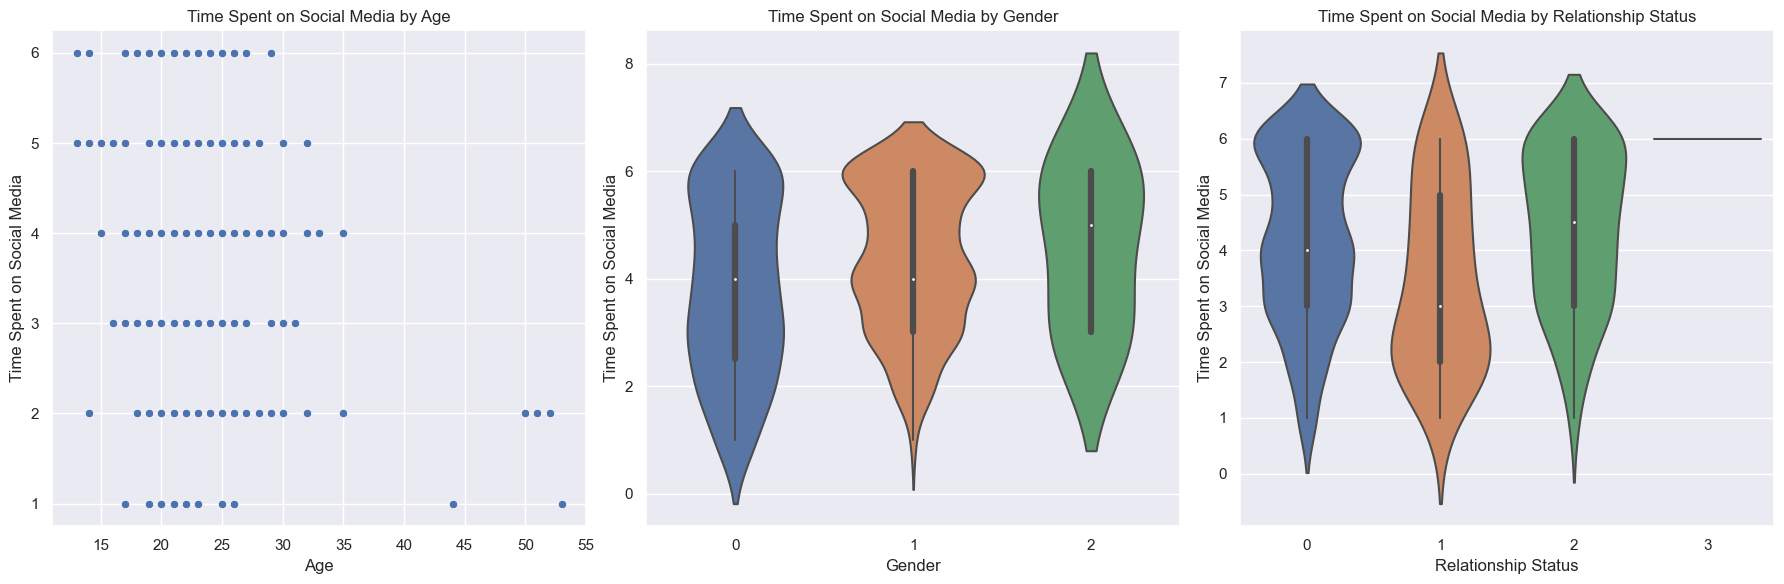

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Subplot 1: Time spent on social media across different age groups
sns.scatterplot(x=data['Age'], y=data['Time (hrs)'], data=data, ax=axes[0])
axes[0].set_title('Time Spent on Social Media by Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Time Spent on Social Media')

# Subplot 2: Time spent on social media across different genders
sns.violinplot(x=data['Gender'], y=data['Time (hrs)'], data=data, ax=axes[1])
axes[1].set_title('Time Spent on Social Media by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Time Spent on Social Media')

# Subplot 3: Time spent on social media across different relationship statuses
sns.violinplot(x=data['Relationship Status'], y=data['Time (hrs)'], data=data, ax=axes[2])
axes[2].set_title('Time Spent on Social Media by Relationship Status')
axes[2].set_xlabel('Relationship Status')
axes[2].set_ylabel('Time Spent on Social Media')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

### Number of platforms

In [ ]:
#Distribution of platform count
sns.histplot(data=data, x=data['Platform Count'], bins=8, kde=True).set(
    title='Distribution of platform count')

#Shapiro wilkes test 
res = stats.shapiro(data['Platform Count'])
print('the p-value of the Shapiro-Wilkes test is', res.pvalue)

Number of platforms used by demographic

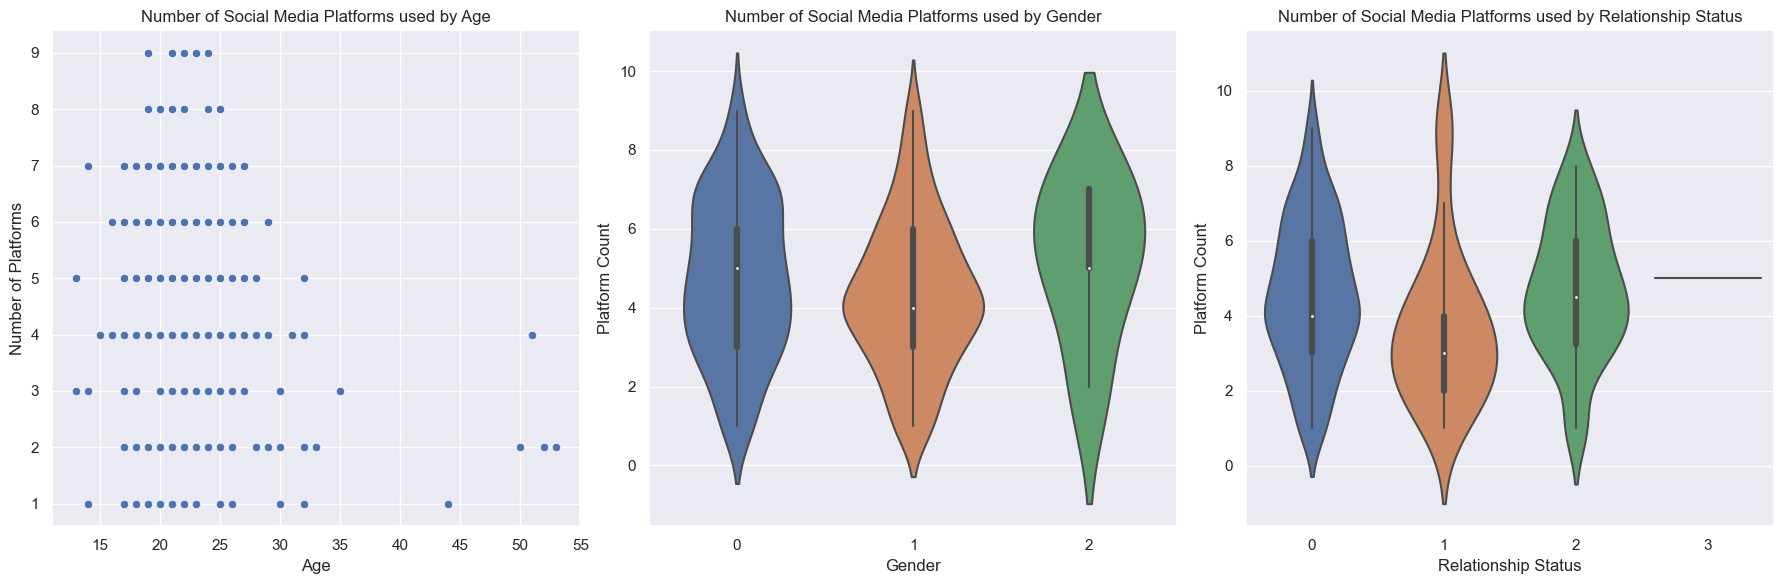

In [100]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Subplot 1: # of platforms on social media across different age groups
sns.scatterplot(x=data['Age'], y=data['Platform Count'], data=data, ax=axes[0])
axes[0].set_title('Number of Social Media Platforms used by Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Number of Platforms')

# Subplot 2: # of platforms on social media across different genders
sns.violinplot(x=data['Gender'], y=data['Platform Count'], data=data, ax=axes[1])
axes[1].set_title('Number of Social Media Platforms used by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Number of Platforms')

# Subplot 3: # of platforms on social media across different relationship statuses
sns.violinplot(x=data['Relationship Status'], y=data['Platform Count'], data=data, ax=axes[2])
axes[2].set_title('Number of Social Media Platforms used by Relationship Status')
axes[2].set_xlabel('Relationship Status')
axes[2].set_ylabel('Number of Platforms')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Mental Health Scores & Outcomes

Next up, let's see how the mental health scores are distributed in our sample of total participants.

### Total Mental Health Scores

In [ ]:
#Now, mental health scores:
sns.histplot(data=data, x=data['Total Score'], kde=True).set(
    title='Overall Distribution of Total Mental Scores') #graph looks normal.

#Shapiro wilkes test 
res = stats.shapiro(data['Total Score'])
print('the p-value of the Shapiro-Wilkes test is', res.pvalue)

Mental health scores by demographic

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Subplot 1: total mental health scores across different age groups
sns.scatterplot(x=data['Age'], y=data['Total Score'], data=data, ax=axes[0])
axes[0].set_title('Total Mental Health Scores by Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Total Score')

# Subplot 2: total mental health scores across different genders
sns.violinplot(x=data['Gender'], y=data['Total Score'], data=data, ax=axes[1])
axes[1].set_title('Total Mental Health Scores used by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Total Score')

# Subplot 3: total mental health scores across different relationship statuses
sns.violinplot(x=data['Relationship Status'], y=data['Total Score'], data=data, ax=axes[2])
axes[2].set_title('Total Mental Health Scores by Relationship Status')
axes[2].set_xlabel('Relationship Status')
axes[2].set_ylabel('Total Score')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

### Mental Health Outcomes

AttributeError: 'numpy.int64' object has no attribute 'startswith'

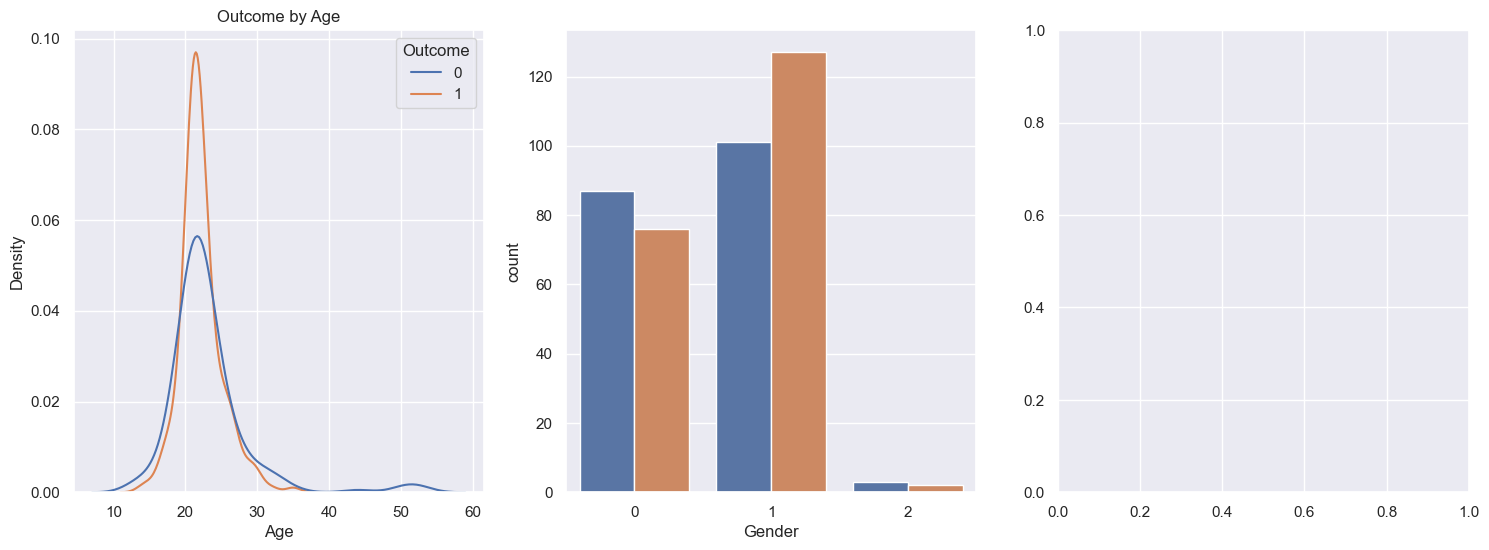

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Subplot 1: Outcomes across different age groups
sns.kdeplot(x=data['Age'], hue=data['Outcome'], data=data, ax=axes[0])
axes[0].set_title('Outcome by Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Density')

# Subplot 2: Outcomes across different genders
gender_str = data['Gender'].astype(str)
sns.countplot(x=gender_str, hue=data['Outcome'], data=data, ax=axes[1])
axes[1].set_title('Outcome by Gender')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Outcome')

# Subplot 3: Outcomes across different relationship statuses
sns.violinplot(x=data['Relationship Status'], y=data['Outcome'], data=data, ax=axes[2])
axes[2].set_title('Outcome by Relationship Status')
axes[2].set_xlabel('Relationship Status')
axes[2].set_ylabel('Total Score')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Relationships between mental health scores and social media usage

Now that we know that our data is normally distributed, we can visualise whether a relationship exists between time spent on social media and mental health scores.

the Pearson Correlation Coefficient is r= 0.3453730111371367 with a p-value of 1.5512760544613927e-12


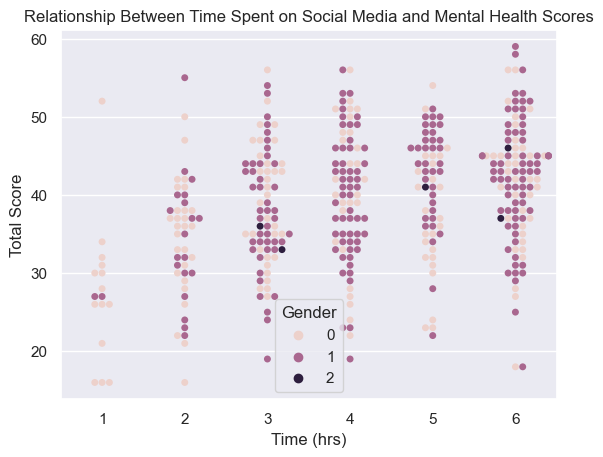

In [113]:
#Plot time spent on social media versus mental health scores
sns.swarmplot(
    data=data, x=data['Time (hrs)'], y=data['Total Score'], hue=data['Gender']).set(
        title='Relationship Between Time Spent on Social Media and Mental Health Scores')
    

#Using Pearson's Coefficient to determine whether this really is a linear relationship
pcoeff = stats.pearsonr(data['Time (hrs)'], 
                        data['Total Score'])
print('the Pearson Correlation Coefficient is r=', pcoeff.statistic, 
      'with a p-value of', pcoeff.pvalue)

We have a positive, linear relationship between the time spent on social media and total mental health scores that is statistiscally significant.

the Pearson Correlation Coefficient is r= 0.13021098529658023 with a p-value of 0.009485893252291983


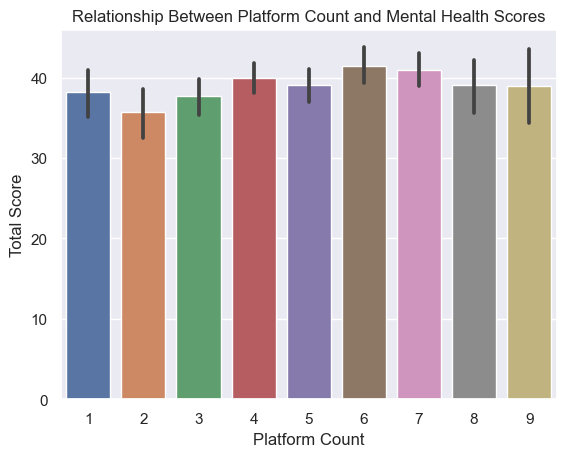

In [114]:
sns.barplot(
    data=data, x=data['Platform Count'], y=data['Total Score']).set(
        title='Relationship Between Platform Count and Mental Health Scores')
    
#Using Pearson's Coefficient to determine whether this really is a linear relationship
pcoeff = stats.pearsonr(data['Platform Count'], 
                        data['Total Score'])
print('the Pearson Correlation Coefficient is r=', pcoeff.statistic, 
      'with a p-value of', pcoeff.pvalue)

So there's a positive correlation between social media usage (in hours) and mental health scores. This is incredibly general though. We're not sure which attributes of the participants are related to mental health scores.

## Mental Health Scores by Demographic
Let's start with age.

Age x Mental health

In [ ]:
sns.scatterplot(data=data, x=data['Age'], y=data['Total Score'])

Gender x Mental health

We can see that our data is relatively even in terms of the male to female ratio, with a small sample of participants in our "Other" category.

## Relationship between Mental Health Scores and Gender

We have our outcomes. What of our demographics?

<Axes: xlabel='Age', ylabel='Total Score'>

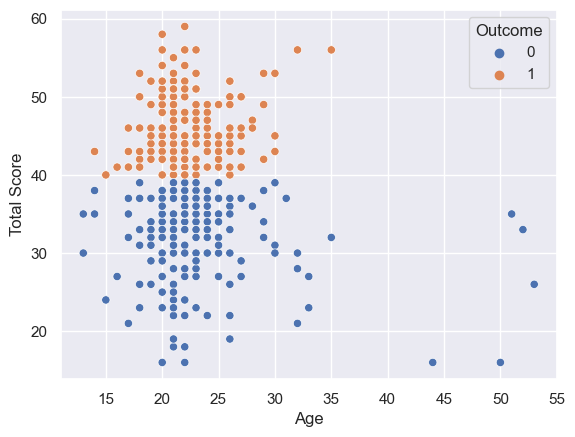

In [115]:
sns.scatterplot(data=data, x=data['Age'], y=data['Total Score'], hue=data['Outcome'])

Let's do a correlation of our data.

In [ ]:
#Ok lets get correlations for mental health scores and our data. 
#First step, we need to convert string indices into integers, starting with Gender
data.loc[data['Gender'] == 'Male', 'Gender'] = 0
data.loc[data['Gender'] == 'Female', 'Gender'] = 1
data.loc[data['Gender'] == 'Other', 'Gender'] = 2
data['Gender'] = data['Gender'].astype('int64')

#Same for relationship status:
data.loc[data['Relationship Status'] == 'Single', 'Relationship Status'] = 0
data.loc[data['Relationship Status'] == 'Married', 'Relationship Status'] = 1
data.loc[data['Relationship Status'] == 'In a relationship', 'Relationship Status'] = 2
data.loc[data['Relationship Status'] == 'Divorced', 'Relationship Status'] = 3
data['Relationship Status'] = data['Relationship Status'].astype('int64')

data.head()

In [ ]:
#dropping unecessary data - using the total questionnaire scores for each parameter.
data.drop(labels=['Anxiety Q1', 'Anxiety Q2', 
                    'Attention Q1', 'Attention Q2', 'Attention Q3', 'Attention Q4',
                    'Depression Q1', 'Depression Q2', 'Depression Q3', 
                    'Self Esteem Q1', 'Self Esteem Q2', 'Self Esteem Q3'], axis=1, inplace=True)

## Correlation heatmap between variables

In [ ]:
#create a correlation table using only numeric values in our data
corrdf = data.corr(method='spearman', numeric_only=True)
corrdf.sort_index(axis=1, ascending=True)
print(corrdf)
#visualise correlation coefficients in a heatmap
sns.heatmap(corrdf)

From the heatmap, and from the correlation table generated, we can conclude that Time Spent on social media has the strongest association with total scores. Interestingly, total self esteem and depression scores didn't seem to have as strong a correlation with time spent on social media as the total anxiety and attention scores did.

## Predicting Mental Health Scores using Machine Learning

Based on the features we have, can we predict mental health outcomes? 

I've chosen to use two types of models: 

1. Linear Regression Model
2. Gaussian Naive Bayes Model

###  Predicting Mental health scores using a Linear Regression model



In [ ]:
#importing the necessary libraries to run our linear regression model
from sklearn.linear_model import LinearRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#Separating our features from our target variable (the variable we want to predict)
X = data[['Time (hrs)', 'Age', 'Gender', 'Relationship Status', 'Platform Count']]
y = data['Total Score']

#create the model
lrmodel = LinearRegression()

#splitting data into test and training sets (60% test, 40% train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#fit the model 
lrmodel.fit(X_train, y_train)

#predictions 
y_pred = lrmodel.predict(X_test)

print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred)}")
print(f"R-squared: {r2_score(y_test, y_pred)}")

In [ ]:
#Gaussian Model: 
gnbmodel = GaussianNB()

#fit the model 
gnbmodel.fit(X_train, y_train)

#predictions 
y_pred = gnbmodel.fit(X_train, y_train).predict(X_test)
